## Stock price prediction using LSTM neural network

### 1. Imports and params

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import logging
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)

In [2]:
# Data Lake params
silver = './data/silver/stock-prices/'
gold = './data/gold/portfolio-optimization/'
silver_table = 'stock_prices.csv'
gold_table = 'portfolio_optimization.csv'

if not os.path.exists(silver):
    os.mkdir(silver)
if not os.path.exists(gold):
    os.mkdir(gold)

# Model params
ticker = ['AAPL','MSFT'] #, 'AMZN','TSLA','GOOGL','GOOG','NVDA','BRK-B','META','UNH','^GSPC']
metric_to_predict = 'Adj Close'
days_to_predict = 3 # Short-term future days to predict
pred_span_days = 60 # Set the number of days used for prediction
backward_steps = 180 # Set the backward steps to go from the last observation available

# Model hyperparms
units = [64, 128]
dropout_rate = [0.1, 0.2]
learning_rate = [0.01, 0.1]
epochs = [25, 50]
batch_size = [32, 64]

### 2. Model pipeline definition

In [3]:
# Model pipeline
def pred_model_pipe(ticker):
    # Function to generate the data tail to predict
    def get_data_tail(input_data, backward_steps, scaler):
        # Extract the relevant portion of the dataset for model inputs
        input_data_pred = input_data[len(input_data) - len(input_data.iloc[-backward_steps:,:]) - pred_span_days:].values

        # Reshape the model inputs to a 2D array with a single column
        input_data_pred = input_data_pred.reshape(-1, 1)

        # Apply the same scaling used for training data to the model inputs
        input_data_pred = scaler.transform(input_data_pred)

        return input_data_pred

    # Build the LSTM model
    def create_model(units, dropout_rate, learning_rate):
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, input_shape=(pred_span_days, 1)))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=int(units/2), return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=int(units/4), return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=int(units/8)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model
    
    print('\n\n')
    print('********** '+ticker+' **********')
    print('\n')

    # Load the data
    input_data = pd.DataFrame(data[data['Ticker']==ticker][metric_to_predict])

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(input_data[metric_to_predict].values.reshape(-1,1))

    # Initialize empty lists for training data input and output
    x_train = []
    y_train = []

    # Iterate through the scaled data, starting from the pred_span_days index
    for x in range(pred_span_days, len(scaled_data)):
        # Append the previous 'pred_span_days' values to x_train
        x_train.append(scaled_data[x - pred_span_days:x, 0])
        # Append the current value to y_train
        y_train.append(scaled_data[x, 0])

    # Convert the x_train and y_train lists to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Extract the relevant portion of the dataset for model inputs
    input_data_pred = get_data_tail(input_data, backward_steps, scaler)

    # Initialize an empty list for test data input
    x_test = []

    # Iterate through the model inputs, starting from the pred_span_days index
    for x in range(pred_span_days, len(input_data_pred)):
        # Append the previous 'pred_span_days' values to x_test
        x_test.append(input_data_pred[x-pred_span_days:x, 0])

    # Convert the x_test list to a numpy array
    x_test = np.array(x_test)

    # Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Data to validate the predictions made
    y_test = input_data.iloc[-backward_steps:,:].values

    # Define the hyperparameters and their ranges for random search
    param_grid = {
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'batch_size': batch_size
    }

    # Define Keras Regressor
    model = KerasRegressor(build_fn=create_model, verbose=0)

    # Perform random search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=5,
        cv=3,
        random_state=42
    )
    random_search.fit(x_train, y_train)

    # Print the best hyperparameters and their corresponding score
    print('Best Parameters:', random_search.best_params_)
    print('Best Score:', random_search.best_score_)

    # Generate price predictions using the LSTM model
    y_pred = np.reshape(random_search.predict(x_test), (-1, 1))

    # Invert the scaling applied to the predicted prices to obtain actual values
    y_pred = scaler.inverse_transform(y_pred)

    # Plot the actual and predicted prices
    plt.plot(y_test, color='black', label=f'Actual {ticker} price')
    plt.plot(y_pred, color='green', label=f'Predicted {ticker} price')
    plt.title(f'{ticker} share price')
    plt.xlabel('time')
    plt.ylabel(f'{ticker} share price')
    plt.legend()
    plt.show()

    # Calculate performance metrics
    mse = np.mean(np.power(y_test - y_pred, 2))
    rmse = np.sqrt(np.mean(np.power(y_test - y_pred, 2)))
    mae = np.mean(np.abs(y_test - y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Print errors
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Absolute Percentage Error: {mape:.4f}%')
    print('\n')

    # Make predictions for future dates (short-term)
    pred_data = input_data
    for j in range(1, days_to_predict+1):
        lst=[]
        input_data_pred = get_data_tail(pred_data, backward_steps, scaler)
        last_date = pd.to_datetime(pred_data.reset_index().iloc[-1,0])+pd.DateOffset(days=1)
        lst.append(last_date)
        pred_prices = pd.DataFrame(lst, columns=['Date'])
        real_data = [input_data_pred[len(input_data_pred) - pred_span_days:len(input_data_pred), 0]]
        real_data = np.array(real_data)
        real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
        prediction = np.reshape(random_search.predict(real_data), (-1, 1))
        prediction = scaler.inverse_transform(prediction)
        pred_prices[metric_to_predict] = prediction
        pred_data = pd.concat((pred_data.reset_index(), pred_prices), axis=0).reset_index(drop=True).set_index('Date')
        
    return pred_data

### 3. Read data from data lake (silver layer)

In [4]:
# Read data from data lake
data = pd.read_csv(silver+silver_table)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2022-05-06,156.009995,159.440002,154.179993,157.279999,156.562683,116124600,AAPL
2022-05-09,154.929993,155.830002,151.490005,152.059998,151.366486,131577900,AAPL
2022-05-10,155.520004,156.740005,152.929993,154.509995,153.805313,115366700,AAPL
2022-05-11,153.500000,155.449997,145.809998,146.500000,145.831848,142689800,AAPL
2022-05-12,142.770004,146.199997,138.800003,142.559998,141.909821,182602000,AAPL


### 4. Model pipeline execution




********** AAPL **********


Best Parameters: {'units': 128, 'learning_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 64}
Best Score: -0.01676349403957526


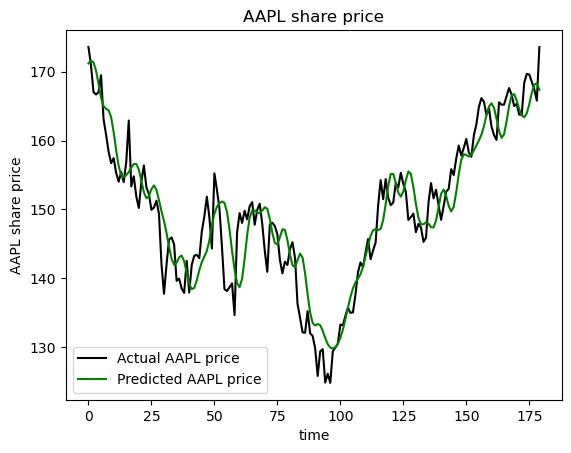

Mean Squared Error: 18.0272
Root Mean Squared Error: 4.2458
Mean Absolute Error: 3.3962
Mean Absolute Percentage Error: 2.3025%





********** MSFT **********


Best Parameters: {'units': 128, 'learning_rate': 0.01, 'epochs': 25, 'dropout_rate': 0.1, 'batch_size': 64}
Best Score: -0.016820332035422325


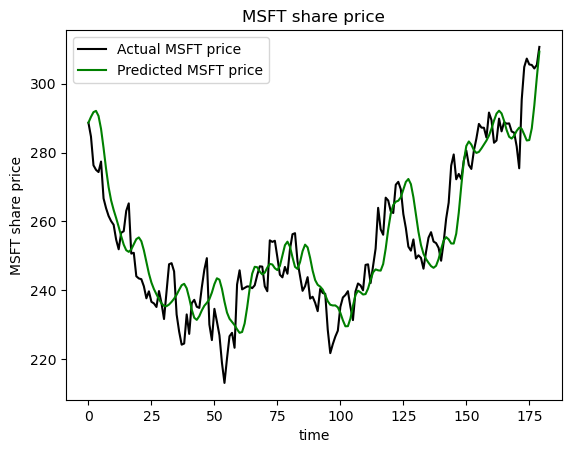

Mean Squared Error: 89.1456
Root Mean Squared Error: 9.4417
Mean Absolute Error: 7.6230
Mean Absolute Percentage Error: 3.0193%




In [5]:
# Model pipe execution
gld_data = pd.DataFrame()
for i in ticker:
    pred_data = pred_model_pipe(i)
    ticker_pred_data = pd.concat([data[data['Ticker']==i][[metric_to_predict]], pred_data.iloc[-days_to_predict:,:]])
    ticker_pred_data['Ticker']=i
    gld_data = pd.concat([gld_data, ticker_pred_data])

### 5. Load curated data to gold layer

In [6]:
# Load data to data lake (gold layer)
gld_data.to_csv(gold+gold_table)
gld_data

,Adj Close,Ticker
Date,,
2022-05-06,156.562683,AAPL
2022-05-09,151.366486,AAPL
2022-05-10,153.805313,AAPL
2022-05-11,145.831848,AAPL
2022-05-12,141.909821,AAPL
...,...,...
2023-05-04,305.410004,MSFT
2023-05-05,310.649994,MSFT
2023-05-06,314.339020,MSFT
